In [4]:
# Install required packages
get_ipython().system('pip install tensorflow==2.14.1 opencv-python matplotlib scikit-learn tqdm')

In [5]:
import cv2
import os
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt
import shutil
from datetime import datetime

# Import tensorflow dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, Lambda
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [6]:
# Define paths for our data
base_dir = os.path.join(os.getcwd(), 'data')
ANC_PATH = os.path.join(base_dir, 'anchor')
POS_PATH = os.path.join(base_dir, 'positive')
NEG_PATH = os.path.join(base_dir, 'negative')

# Create directories if they don't exist
for dir_path in [base_dir, ANC_PATH, POS_PATH, NEG_PATH]:
    os.makedirs(dir_path, exist_ok=True)
    
print(f"Directory structure set up at {base_dir}")
print(f"Anchor images will be stored in: {ANC_PATH}")
print(f"Positive images will be stored in: {POS_PATH}")
print(f"Negative images will be stored in: {NEG_PATH}")

Directory structure set up at c:\Users\danny\OneDrive\Documents\code\Facial Recognition\data
Anchor images will be stored in: c:\Users\danny\OneDrive\Documents\code\Facial Recognition\data\anchor
Positive images will be stored in: c:\Users\danny\OneDrive\Documents\code\Facial Recognition\data\positive
Negative images will be stored in: c:\Users\danny\OneDrive\Documents\code\Facial Recognition\data\negative


In [7]:
def download_lfw_dataset():
    """
    Download and prepare the LFW dataset from Kaggle as negative examples.
    """
    try:
        # First try to install kagglehub if it's not already installed
        import importlib
        if importlib.util.find_spec("kagglehub") is None:
            print("Installing kagglehub...")
            import subprocess
            subprocess.check_call(['pip', 'install', 'kagglehub'])
        
        # Import kagglehub
        import kagglehub
        
        # Download the LFW dataset
        print("Downloading LFW dataset from Kaggle...")
        dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
        
        print(f"Dataset downloaded to: {dataset_path}")
        
        # Process the dataset for negative examples
        lfw_images_dir = os.path.join(dataset_path, "lfw-deepfunneled")
        
        # Make sure our negative directory exists
        os.makedirs(NEG_PATH, exist_ok=True)
        
        # Count and process images
        count = 0
        for root, dirs, files in os.walk(lfw_images_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    # Get person name from folder
                    person_name = os.path.basename(root)
                    
                    # Create unique filename
                    new_filename = f"{person_name}_{file}"
                    
                    # Source and destination paths
                    src_file = os.path.join(root, file)
                    dest_file = os.path.join(NEG_PATH, new_filename)
                    
                    # Copy the file
                    shutil.copy2(src_file, dest_file)
                    count += 1
                    
                    if count % 100 == 0:
                        print(f"Processed {count} files...")
        
        print(f"Successfully copied {count} images to your negative examples folder")
        return dataset_path
    
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("\nYou can manually download from: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset")
        return None

def setup_lfw_negative_examples():
    """
    Complete workflow function to set up LFW dataset as negative examples.
    """
    print("Setting up LFW dataset as negative examples...")
    
    # Check if we already have sufficient negative examples
    if os.path.exists(NEG_PATH):
        neg_count = len([f for f in os.listdir(NEG_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if neg_count > 100:
            print(f"You already have {neg_count} negative examples.")
            proceed = input("Do you want to download more? (y/n): ")
            if proceed.lower() != 'y':
                return
    
    # Download the dataset
    dataset_path = download_lfw_dataset()
    
    if dataset_path:
        print("\nNegative examples setup complete!")

In [8]:
# Run this cell to download and setup negative examples from Kaggle
setup_lfw_negative_examples()

Setting up LFW dataset as negative examples...
You already have 13233 negative examples.


In [9]:
def collect_face_data():
    """
    Collect anchor and positive images using webcam.
    """
    # Set up camera
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
    
    # Set up counters
    anchor_count = len(os.listdir(ANC_PATH))
    positive_count = len(os.listdir(POS_PATH))
    
    # Create window
    window_name = 'Face Collection'
    cv2.namedWindow(window_name)
    
    print("Face collection window opened:")
    print("Press 'a' to capture anchor images (mog the camera)")
    print("Press 'p' to capture positive images (different angles and emotions)")
    print("Press 'q' to quit")
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret:
                print("Failed to grab frame")
                break
                
            # Create a copy for display
            display_frame = frame.copy()
            
            # Define the region of interest
            h, w = frame.shape[:2]
            center_x, center_y = w // 2, h // 2
            face_size = 250
            
            # Calculate crop coordinates
            x1 = max(0, center_x - face_size // 2)
            y1 = max(0, center_y - face_size // 2)
            x2 = min(w, x1 + face_size)
            y2 = min(h, y1 + face_size)
            
            # Draw rectangle
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add text
            cv2.putText(display_frame, f"Anchors: {anchor_count} | Positives: {positive_count}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(display_frame, "Press 'a' for anchor, 'p' for positive, 'q' to quit", 
                       (10, h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            # Display the frame
            cv2.imshow(window_name, display_frame)
            
            # Process keyboard input
            key = cv2.waitKey(1) & 0xFF
            
            # Crop the face region
            face_crop = frame[y1:y2, x1:x2].copy()
            
            if key == ord('a'):
                # Save anchor image
                imgname = os.path.join(ANC_PATH, f'{uuid.uuid4()}.jpg')
                cv2.imwrite(imgname, face_crop)
                anchor_count += 1
                print(f"Anchor image saved! Total: {anchor_count}")
                
            elif key == ord('p'):
                # Save positive image
                imgname = os.path.join(POS_PATH, f'{uuid.uuid4()}.jpg')
                cv2.imwrite(imgname, face_crop)
                positive_count += 1
                print(f"Positive image saved! Total: {positive_count}")
                
            elif key == ord('q'):
                break
    
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print(f"Collection complete. Anchors: {anchor_count}, Positives: {positive_count}")


In [19]:
# Run when you're ready to collect face images
collect_face_data()

Face collection window opened:
Press 'a' to capture anchor images (mog the camera)
Press 'p' to capture positive images (different angles and emotions)
Press 'q' to quit
Collection complete. Anchors: 30, Positives: 30


In [10]:
def preprocess_image(file_path):
    """
    Preprocess an image for the model.
    """
    # Read and decode image
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize to 100x100
    img = tf.image.resize(img, (100, 100))
    
    # Normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    return img

def preprocess_twin(input_img, validation_img, label):
    """
    Preprocess both images in a pair.
    """
    return (preprocess_image(input_img), preprocess_image(validation_img), label)


In [11]:
def create_dataset(anchor_path, positive_path, negative_path, samples_per_class=300, test_split=0.3, batch_size=16):
    """
    Create training and testing datasets
    """
    # Get file lists
    anchor_files = tf.data.Dataset.list_files(anchor_path + '/*.jpg').take(samples_per_class)
    positive_files = tf.data.Dataset.list_files(positive_path + '/*.jpg').take(samples_per_class)
    negative_files = tf.data.Dataset.list_files(negative_path + '/*.jpg').take(samples_per_class)
    
    # Convert to lists to get actual count
    anchor_list = list(anchor_files)
    positive_list = list(positive_files)
    negative_list = list(negative_files)
    
    # Get the minimum count to ensure balanced dataset
    min_samples = min(len(anchor_list), len(positive_list), len(negative_list))
    
    print(f"Using {min_samples} samples per class")
    
    # Recreate datasets with exact counts
    anchor = tf.data.Dataset.from_tensor_slices(anchor_list[:min_samples])
    positive = tf.data.Dataset.from_tensor_slices(positive_list[:min_samples])
    negative = tf.data.Dataset.from_tensor_slices(negative_list[:min_samples])
    
    # Create positive pairs
    positives = tf.data.Dataset.zip((
        anchor,
        positive,
        tf.data.Dataset.from_tensor_slices(tf.ones(min_samples, dtype=tf.float32))
    ))
    
    # Create negative pairs
    negatives = tf.data.Dataset.zip((
        anchor,
        negative,
        tf.data.Dataset.from_tensor_slices(tf.zeros(min_samples, dtype=tf.float32))
    ))
    
    # Combine datasets
    data = positives.concatenate(negatives)
    
    # Preprocess and prepare - THIS IS THE KEY FIX
    def preprocess_and_format(anchor_path, validation_path, label):
        """Preprocess and format data for the model"""
        anchor_img = preprocess_image(anchor_path)
        validation_img = preprocess_image(validation_path)
        # Return as a tuple of (inputs_dict, label)
        return {"input_img": anchor_img, "validation_img": validation_img}, label
    
    # Apply preprocessing with correct format
    data = data.map(preprocess_and_format)
    data = data.cache()
    data = data.shuffle(buffer_size=1024)
    
    # Calculate split
    total_samples = min_samples * 2  # positive + negative pairs
    train_size = int(total_samples * (1 - test_split))
    
    # Split into train and test
    train_data = data.take(train_size)
    train_data = train_data.batch(batch_size)
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    
    test_data = data.skip(train_size)
    test_data = test_data.batch(batch_size)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)
    
    print(f"Training samples: ~{train_size}, Test samples: ~{total_samples - train_size}")
    
    return train_data, test_data

In [22]:
# Run you have collected all your images
train_data, test_data = create_dataset(ANC_PATH, POS_PATH, NEG_PATH)

Using 30 samples per class
Training samples: ~42, Test samples: ~18


In [12]:
def make_embedding():
    """
    Build the embedding network.
    """
    inp = Input(shape=(100, 100, 3), name='embedding_input')
    
    # Convolutional blocks
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(pool_size=(2, 2), padding='same')(c1)
    
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(pool_size=(2, 2), padding='same')(c2)
    
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(pool_size=(2, 2), padding='same')(c3)
    
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [13]:
def make_siamese_model():
    """
    Build the Siamese network
    """
    # Create embedding model
    embedding = make_embedding()
    
    # Define inputs
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Generate embeddings
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)
    
    # Calculate L1 distance using a Dense layer instead of Lambda
    # First concatenate the absolute differences
    l1_distance = tf.abs(input_embedding - validation_embedding)
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid', name='output')(l1_distance)
    
    # Create model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [14]:
def train_siamese_model(train_data, test_data, epochs=50, learning_rate=1e-4):
    """
    Train the Siamese model
    """
    # Create the model
    print("Creating Siamese model...")
    siamese_model = make_siamese_model()
    
    # Print model summary
    siamese_model.summary()
    
    # Compile model
    siamese_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    # Test the data format before training
    print("\nTesting data format...")
    for data_batch in train_data.take(1):
        if len(data_batch) == 2:
            inputs, labels = data_batch
            if isinstance(inputs, tuple) and len(inputs) == 2:
                print(f"✓ Data format is correct!")
                print(f"  Input 1 shape: {inputs[0].shape}")
                print(f"  Input 2 shape: {inputs[1].shape}")
                print(f"  Labels shape: {labels.shape}")
            else:
                print("✗ Data format issue detected!")
                print(f"  Inputs type: {type(inputs)}")
                print(f"  Inputs content: {inputs}")
        else:
            print(f"✗ Unexpected data format: {len(data_batch)} elements")
    
    # Create directories
    checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Callbacks
    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, f'siamese_{timestamp}_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Train the model
    print("\nStarting training...")
    history = siamese_model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    final_path = f'siamese_model_{timestamp}.h5'
    siamese_model.save(final_path)
    print(f"Model saved to {final_path}")
    
    return siamese_model, history

In [26]:
# Run when you're ready to train the model
siamese_model, history = train_siamese_model(train_data, test_data, epochs=50)

Creating Siamese model...
Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                           

c:\Users\danny\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 676ms/step - loss: 0.6895 - accuracy: 0.7619 - precision: 0.6667 - recall: 0.9474 - val_loss: 0.6673 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.9762 - precision: 0.9583 - recall: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
3/3 [==============================] - 1s 402ms/step - loss: 0.6541 - accuracy: 0.9762 - precision: 0.9583 - recall: 1.0000 - val_loss: 0.6095 - val_accuracy: 0.9444 - val_precision: 0.9091 - val_recall: 1.0000
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
3/3 [==============================] - 1s 409ms/step - loss: 0.5623 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4258 - val_accuracy: 0.9444 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 4

In [15]:
def evaluate_model(model, test_data):
    """
    Evaluate the model performance - FIXED VERSION
    """
    print("Evaluating model...")
    
    # Initialize lists for all predictions and labels
    all_predictions = []
    all_labels = []
    
    # Get a sample batch for visualization
    sample_batch = None
    
    # Iterate through test data
    for batch in test_data:
        # Handle different data formats
        if len(batch) == 2:  # Format: ((input1, input2), labels)
            inputs, y_true = batch
            if isinstance(inputs, tuple) and len(inputs) == 2:
                test_input, test_val = inputs
            else:
                print("Unexpected input format")
                continue
        elif len(batch) == 3:  # Format: (input1, input2, labels)
            test_input, test_val, y_true = batch
        else:
            print(f"Unexpected batch format with {len(batch)} elements")
            continue
        
        # Store first batch for visualization
        if sample_batch is None:
            sample_batch = (test_input, test_val, y_true)
        
        # Make predictions
        y_pred = model.predict([test_input, test_val], verbose=0)
        
        all_predictions.extend(y_pred)
        all_labels.extend(y_true.numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    binary_predictions = (all_predictions > 0.5).astype(int).flatten()
    accuracy = np.mean(binary_predictions == all_labels)
    
    # Calculate precision and recall
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(all_labels, binary_predictions, zero_division=0)
    recall = recall_score(all_labels, binary_predictions, zero_division=0)
    
    print(f"\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Visualize some examples if we have a sample batch
    if sample_batch is not None:
        test_input, test_val, y_true = sample_batch
        y_hat = model.predict([test_input, test_val], verbose=0)
        
        plt.figure(figsize=(15, 8))
        
        num_examples = min(4, len(test_input))
        for i in range(num_examples):
            # Anchor image
            plt.subplot(num_examples, 3, 3*i + 1)
            plt.imshow(test_input[i])
            plt.title('Anchor')
            plt.axis('off')
            
            # Comparison image
            plt.subplot(num_examples, 3, 3*i + 2)
            plt.imshow(test_val[i])
            plt.title('Comparison')
            plt.axis('off')
            
            # Prediction
            plt.subplot(num_examples, 3, 3*i + 3)
            pred_val = y_hat[i][0]
            true_val = y_true[i].numpy()
            match = "MATCH" if pred_val > 0.5 else "NO MATCH"
            color = 'green' if (pred_val > 0.5) == true_val else 'red'
            
            plt.text(0.5, 0.5, f"{match}\nConf: {pred_val:.2f}\nTrue: {true_val}", 
                    ha='center', va='center', fontsize=12, color=color)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [16]:
def plot_training_history(history):
    """
    Plot training metrics.
    """
    metrics = ['loss', 'accuracy']
    
    plt.figure(figsize=(12, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


Evaluating model...
Unexpected input format
Unexpected input format

Test Results:
Accuracy: nan
Precision: 0.0000
Recall: 0.0000


c:\Users\danny\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\danny\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


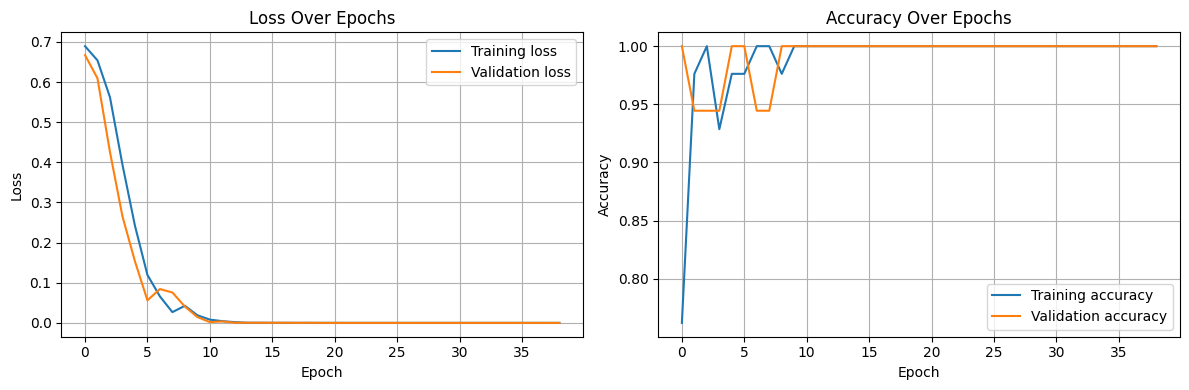

In [33]:
# Evaluate the trained model
evaluate_model(siamese_model, test_data)

# Plot training history
plot_training_history(history)

In [17]:
def verify_face(model, verification_threshold=0.5):
    """
    Real-time face verification system.
    """
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
    
    anchor_image = None
    
    print("\nFace Verification System")
    print("Press 'c' to capture reference face")
    print("Press 'v' to start verification")
    print("Press 'q' to quit")
    
    verification_active = False
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            display_frame = frame.copy()
            h, w = frame.shape[:2]
            
            # Draw face region
            face_size = 250
            x1 = w // 2 - face_size // 2
            y1 = h // 2 - face_size // 2
            x2 = x1 + face_size
            y2 = y1 + face_size
            
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Instructions
            cv2.putText(display_frame, "Position face in green box", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('c'):
                # Capture reference
                face_crop = frame[y1:y2, x1:x2]
                anchor_image = cv2.resize(face_crop, (100, 100)) / 255.0
                print("Reference face captured!")
                verification_active = False
                
            elif key == ord('v') and anchor_image is not None:
                verification_active = True
                print("Verification active!")
                
            elif key == ord('q'):
                break
            
            # Perform verification
            if verification_active and anchor_image is not None:
                face_crop = frame[y1:y2, x1:x2]
                comparison_image = cv2.resize(face_crop, (100, 100)) / 255.0
                
                # Prepare batch
                anchor_batch = np.expand_dims(anchor_image, axis=0)
                comparison_batch = np.expand_dims(comparison_image, axis=0)
                
                # Predict
                result = model.predict([anchor_batch, comparison_batch], verbose=0)[0][0]
                
                # Display result
                if result > verification_threshold:
                    text = f"MATCH ({result*100:.1f}%)"
                    color = (0, 255, 0)
                else:
                    text = f"NO MATCH ({(1-result)*100:.1f}%)"
                    color = (0, 0, 255)
                
                cv2.putText(display_frame, text, (10, 70), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            cv2.imshow('Face Verification', display_frame)
    
    finally:
        cap.release()
        cv2.destroyAllWindows()


In [ ]:
# To load a previously trained model, uncomment and modify the path
# siamese_model = tf.keras.models.load_model('path/to/your/model.h5', 
#                                           custom_objects={'L1Dist': L1Dist})

In [36]:
# Run to run the face verification system
verify_face(siamese_model)


Face Verification System
Press 'c' to capture reference face
Press 'v' to start verification
Press 'q' to quit
Reference face captured!
Verification active!


In [18]:
def run_complete_workflow():
    """
    Run the complete workflow - FIXED VERSION
    """
    print("=== Facial Recognition System Setup ===\n")
    
    try:
        # Step 1: Check data
        print("Step 1: Checking data directories...")
        
        # Count existing images
        anc_count = len([f for f in os.listdir(ANC_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))])
        pos_count = len([f for f in os.listdir(POS_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))])
        neg_count = len([f for f in os.listdir(NEG_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        print(f"Current image counts:")
        print(f"  Anchor images: {anc_count}")
        print(f"  Positive images: {pos_count}")
        print(f"  Negative images: {neg_count}")
        
        # Step 2: Collect data if needed
        if anc_count < 20 or pos_count < 20:
            print("\nYou need at least 20 anchor and positive images.")
            if input("Collect face images now? (y/n): ").lower() == 'y':
                collect_face_data()
        
        if neg_count < 100:
            print("\nYou need negative examples for training.")
            if input("Download LFW dataset? (y/n): ").lower() == 'y':
                setup_lfw_negative_examples()
        
        # Step 3: Create datasets
        print("\nStep 3: Creating datasets...")
        train_data, test_data = create_dataset(ANC_PATH, POS_PATH, NEG_PATH)
        
        # Step 4: Train model
        if input("\nTrain the model? (y/n): ").lower() == 'y':
            epochs = int(input("Number of epochs (default 50): ") or "50")
            
            siamese_model, history = train_siamese_model(train_data, test_data, epochs=epochs)
            
            # Step 5: Evaluate
            print("\nEvaluating model...")
            evaluate_model(siamese_model, test_data)
            plot_training_history(history)
            
            # Step 6: Test verification
            if input("\nTest face verification? (y/n): ").lower() == 'y':
                verify_face(siamese_model)
            
            return siamese_model, history
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()
    
    return None, None

=== Facial Recognition System Setup ===

Step 1: Checking data directories...
Current image counts:
  Anchor images: 30
  Positive images: 30
  Negative images: 13233

Step 3: Creating datasets...
Using 30 samples per class
Training samples: ~42, Test samples: ~18
Creating Siamese model...
Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                           

c:\Users\danny\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 690ms/step - loss: 0.6839 - accuracy: 0.7381 - precision: 0.8824 - recall: 0.6250 - val_loss: 0.6180 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
3/3 [==============================] - 1s 404ms/step - loss: 0.6016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5466 - val_accuracy: 0.9444 - val_precision: 0.9091 - val_recall: 1.0000
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.9524 - precision: 0.9565 - recall: 0.9565
Epoch 3: val_accuracy did not improve from 1.00000
3/3 [==============================] - 1s 402ms/step - loss: 0.4602 - accuracy: 0.9524 - precision: 0.9565 - recall: 0.9565 - val_loss: 0.3497 - val_accuracy: 0.9444 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 4

c:\Users\danny\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\danny\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Test Results:
Accuracy: nan
Precision: 0.0000
Recall: 0.0000


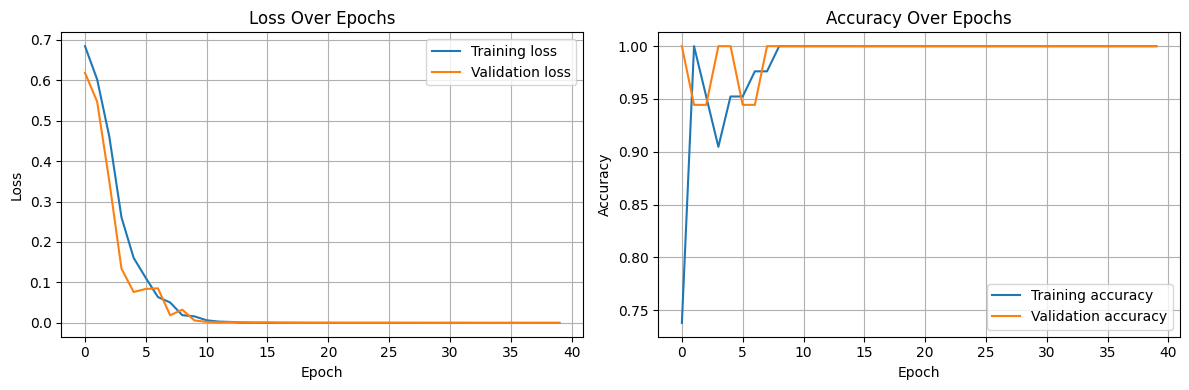


Face Verification System
Press 'c' to capture reference face
Press 'v' to start verification
Press 'q' to quit
Reference face captured!
Verification active!


In [19]:
# Uncomment to run the complete workflow from start to finish (if preferred)
siamese_model, history = run_complete_workflow()

In [ ]:
"""
Facial Recognition System with Siamese Networks

This notebook implements a complete facial verification system that can determine 
if two face images belong to the same person. Key features include:

1. Data Collection:
   - Capture anchor and positive images of your face using webcam
   - Download and process the LFW dataset for negative examples
   - Interactive interface with buttons instead of keyboard shortcuts

2. Model Architecture:
   - Siamese Neural Network with shared weights
   - L1 Distance layer to compare face embeddings
   - Binary classification (same/different person)

3. Training:
   - Data augmentation for better generalization
   - Dropout for regularization
   - Proper metrics (accuracy, precision, recall)
   - Early stopping and model checkpointing

4. Real-time Verification:
   - Interactive webcam-based verification
   - Reference image capture and comparison
   - Confidence scores and visual feedback

Usage Instructions:
1. Run the complete workflow with run_complete_workflow()
   
-- OR --

1. Download negative examples using setup_lfw_negative_examples()
2. Collect your face images using collect_face_data()
3. Create datasets with create_dataset()
4. Train the model using train_siamese_model()
5. Evaluate with evaluate_model() and plot_training_history()
6. Test verification with verify_face()

This implementation uses one-shot learning principles,
allowing it to recognize faces with minimal training examples.
"""